In [27]:
import os
import torch.nn as nn
import torchvision.models as models
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch 
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In [28]:
seed = 42 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [29]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [102]:
class SingleSampleDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_to_idx = {}
        self.idx_to_label = {}
        self.images_in_memory = []  # Store images in RAM

        # Collect image paths and corresponding labels
        for series in os.listdir(root_dir):
            series_path = os.path.join(root_dir, series)
            if os.path.isdir(series_path):
                for img_name in os.listdir(series_path):
                    if ".json" in img_name:
                        continue
                    img_path = os.path.join(series_path, img_name)
                    self.image_paths.append(img_path)
                    
                    label = img_name  
                    if label not in self.label_to_idx:
                        idx = len(self.label_to_idx)
                        self.label_to_idx[label] = idx
                        self.idx_to_label[idx] = label
                    
                    self.labels.append(self.label_to_idx[label])

                    # Load the image into memory
                    image = Image.open(img_path)
                    if image.mode != "RGB":
                        image = image.convert("RGB")
                    self.images_in_memory.append(image)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.images_in_memory[idx]
        label_idx = self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(label_idx), num_classes=len(self.label_to_idx))

        if self.transform:
            image = self.transform(image)

        return image, one_hot_label.float()
    

transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(1, 1),),
    transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.3, hue=0.05),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.96, 1.06)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SingleSampleDataset(root_dir='cards', transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)

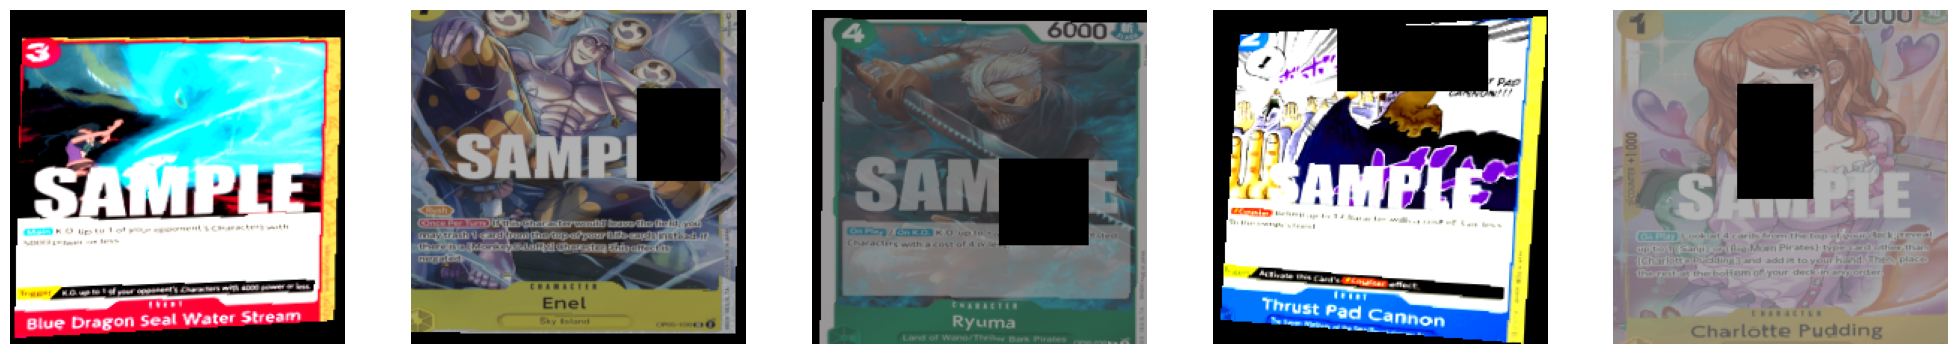

In [103]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# reverse normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

images = images * std[:, None, None] + mean[:, None, None]
images = images.numpy()
images = images.transpose((0, 2, 3, 1))
images = images[:5]
fig, axes = plt.subplots(1, len(images), figsize=(25, 25))
if len(images) == 1:
    axes = [axes]

for i, img in enumerate(images):
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

In [104]:
base_model = models.resnet50(pretrained=True)

# Freeze all layers
for param in base_model.parameters():
    param.requires_grad = False


# Get the number of features from the original fully connected layer
num_ftrs = base_model.fc.in_features
base_model.fc = nn.Identity()

embedding_size = 512

class CardModel(nn.Module):
    def __init__(self, base_model, embedding_size):
        super(CardModel, self).__init__()
        self.base_model = base_model
        self.embedding_layer = nn.Linear(num_ftrs, embedding_size)
        self.classification_layer = nn.Linear(embedding_size, len(dataset.labels))

    def forward(self, x):
        x = self.base_model(x)
        x = self.embedding_layer(x) 
        logits = self.classification_layer(x)
        return x, logits
        
model = CardModel(base_model, embedding_size).to(device)

/home/kono/.local/share/virtualenvs/tcg-scanner-gdmEvyDg/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kono/.local/share/virtualenvs/tcg-scanner-gdmEvyDg/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/kono/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


In [105]:
criterion = nn.CrossEntropyLoss()

def train_loop(num_epochs, optimizer):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, one_hot_labels in train_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)

            optimizer.zero_grad()
            
            embeddings, logits = model(inputs)
            
            labels = torch.argmax(one_hot_labels, dim=1)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.detach()
        
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')


In [106]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_loop(50, optimizer)

Epoch 1/50, Loss: 8.5717, Accuracy: 0.00%
Epoch 2/50, Loss: 9.1307, Accuracy: 0.00%
Epoch 3/50, Loss: 7.4672, Accuracy: 0.00%
Epoch 4/50, Loss: 7.1178, Accuracy: 0.29%
Epoch 5/50, Loss: 6.7353, Accuracy: 0.43%
Epoch 6/50, Loss: 6.2108, Accuracy: 2.36%
Epoch 7/50, Loss: 5.5857, Accuracy: 6.79%
Epoch 8/50, Loss: 5.0112, Accuracy: 11.72%
Epoch 9/50, Loss: 4.3250, Accuracy: 19.09%
Epoch 10/50, Loss: 3.6742, Accuracy: 28.31%
Epoch 11/50, Loss: 3.0878, Accuracy: 39.67%
Epoch 12/50, Loss: 2.5266, Accuracy: 49.54%
Epoch 13/50, Loss: 2.0339, Accuracy: 59.47%
Epoch 14/50, Loss: 1.7482, Accuracy: 65.05%
Epoch 15/50, Loss: 1.4775, Accuracy: 69.26%
Epoch 16/50, Loss: 1.2310, Accuracy: 74.77%
Epoch 17/50, Loss: 1.1411, Accuracy: 77.27%
Epoch 18/50, Loss: 1.0563, Accuracy: 77.06%
Epoch 19/50, Loss: 0.9237, Accuracy: 80.84%
Epoch 20/50, Loss: 0.7637, Accuracy: 83.70%
Epoch 21/50, Loss: 0.7717, Accuracy: 82.27%
Epoch 22/50, Loss: 0.7471, Accuracy: 83.27%
Epoch 23/50, Loss: 0.6306, Accuracy: 85.13%
Epoc

In [107]:
# Optionally, unfreeze more layers and fine-tune with a lower learning rate
for param in model.base_model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
train_loop(25, optimizer)

Epoch 1/25, Loss: 0.2568, Accuracy: 93.35%
Epoch 2/25, Loss: 0.2188, Accuracy: 94.21%
Epoch 3/25, Loss: 0.1262, Accuracy: 96.43%
Epoch 4/25, Loss: 0.1289, Accuracy: 96.35%
Epoch 5/25, Loss: 0.1097, Accuracy: 97.07%
Epoch 6/25, Loss: 0.1070, Accuracy: 97.14%
Epoch 7/25, Loss: 0.0952, Accuracy: 97.43%
Epoch 8/25, Loss: 0.0711, Accuracy: 98.00%
Epoch 9/25, Loss: 0.0562, Accuracy: 98.64%
Epoch 10/25, Loss: 0.0701, Accuracy: 98.00%
Epoch 11/25, Loss: 0.0712, Accuracy: 98.00%
Epoch 12/25, Loss: 0.0512, Accuracy: 98.64%
Epoch 13/25, Loss: 0.0510, Accuracy: 98.36%
Epoch 14/25, Loss: 0.0787, Accuracy: 97.78%
Epoch 15/25, Loss: 0.0428, Accuracy: 98.64%
Epoch 16/25, Loss: 0.0558, Accuracy: 98.71%
Epoch 17/25, Loss: 0.0440, Accuracy: 98.64%
Epoch 18/25, Loss: 0.0414, Accuracy: 99.00%
Epoch 19/25, Loss: 0.0288, Accuracy: 99.07%
Epoch 20/25, Loss: 0.0342, Accuracy: 99.07%
Epoch 21/25, Loss: 0.0357, Accuracy: 99.07%
Epoch 22/25, Loss: 0.0493, Accuracy: 98.78%
Epoch 23/25, Loss: 0.0285, Accuracy: 99.2

In [108]:
torch.save(model.state_dict(), f'{time.time()}_model_state_dict.pth')
torch.save(model, f'{time.time()}_model_save.pth')

In [109]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, one_hot_labels in train_loader:
        labels = torch.argmax(one_hot_labels.to(device), dim=1)
        embeddings, logits = model(inputs.to(device))
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print(f'Accuracy: {100 * correct / total}%')

Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 99.6875%
Accuracy: 99.7159090909091%
Accuracy: 99.73958333333333%
Accuracy: 99.75961538461539%
Accuracy: 99.55357142857143%
Accuracy: 99.58333333333333%
Accuracy: 99.609375%
Accuracy: 99.63235294117646%
Accuracy: 99.65277777777777%
Accuracy: 99.67105263157895%
Accuracy: 99.53125%
Accuracy: 99.4047619047619%
Accuracy: 99.43181818181819%
Accuracy: 99.45652173913044%
Accuracy: 99.47916666666667%
Accuracy: 99.375%
Accuracy: 99.39903846153847%
Accuracy: 99.30555555555556%
Accuracy: 99.33035714285714%
Accuracy: 99.35344827586206%
Accuracy: 99.375%
Accuracy: 99.39516129032258%
Accuracy: 99.31640625%
Accuracy: 99.33712121212122%
Accuracy: 99.35661764705883%
Accuracy: 99.375%
Accuracy: 99.39236111111111%
Accuracy: 99.32432432432432%
Accuracy: 99.25986842105263%
Accuracy: 99.27884615384616%
Accuracy: 99.296875%
Accuracy: 99.31402439024

In [110]:
# preprocesing for forward pass
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet's mean and std
])

def extract_embedding(model, img_path):
    model.eval()
    image = Image.open(img_path)
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = transform(image)
    with torch.no_grad():
        embedding, logits = model(image.unsqueeze(0).to(device))
    return F.normalize(embedding, p=2, dim=1).cpu().numpy().flatten(), logits



In [111]:
import re
def extract_prefix(card_id):
    match = re.match(r'^[^-]+', card_id)
    return match.group(0) if match else ''

OP05-119.jpg


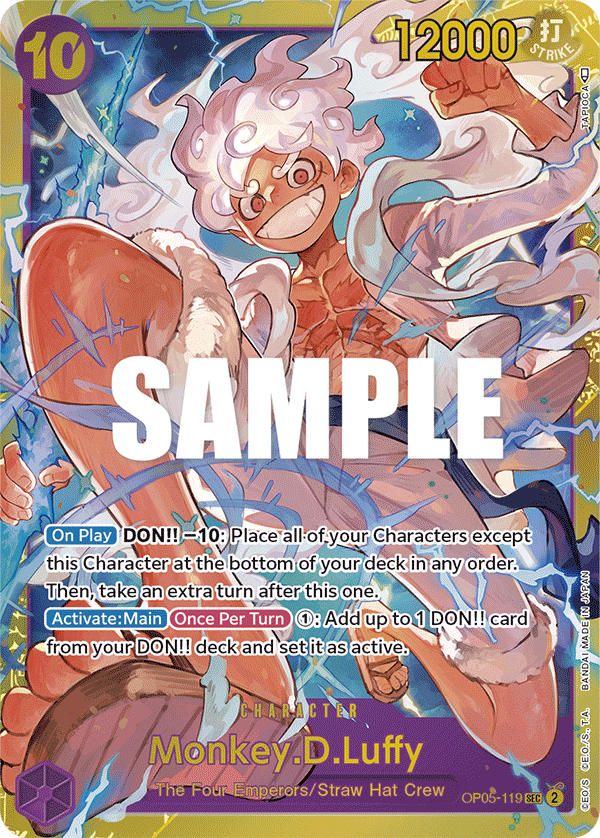

In [112]:
embedding, logits = extract_embedding(model, "monkey.png")

probabilities = F.softmax(logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1)

predicted_class = predicted_class.item()
predicted_class_name = dataset.idx_to_label[predicted_class]
print(predicted_class_name)
image = Image.open("cards/" +  extract_prefix(predicted_class_name) + "/" + predicted_class_name)
image

In [113]:
card_embeddings = []
root_dir = "cards"
index = 0
index_to_card_id = {}

for series in os.listdir(root_dir):
    series_path = os.path.join(root_dir, series)
    if os.path.isdir(series_path):
        for img_name in os.listdir(series_path):
            if ".json" in img_name:
                continue
            img_path = os.path.join(series_path, img_name)
            label = img_name  
            embedding, _ = extract_embedding(model, img_path)
            card_embeddings.append(embedding)
            index_to_card_id[index] = label
            index += 1

In [114]:
from sklearn.metrics.pairwise import euclidean_distances
from pathlib import Path

def find_image_path(card_id, root_dir="cards"):
    root_path = Path(root_dir)
    for image_path in root_path.rglob(f"{card_id}"):
        return image_path
    return None

card_embeddings_np = np.array(card_embeddings, dtype='float32')

# Define a query vector
query_embedding, _ = extract_embedding(model, "monkey.png") 
query_embedding = np.array([query_embedding]) 

distances = euclidean_distances(card_embeddings_np, query_embedding)

# Find the indices of the 5 closest vectors
top_k = 5
closest_indices = np.argsort(distances.flatten())[:top_k]

# Retrieve the closest card IDs
closest_card_ids = [index_to_card_id[idx] for idx in closest_indices]
closest_distances = [distances[idx][0] for idx in closest_indices]

Match 1:
Card ID: OP05-119.jpg
Distance: 0.6165542006492615


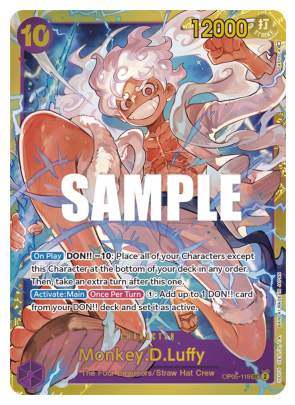

Match 2:
Card ID: OP04-019_p1.jpg
Distance: 0.8533164262771606


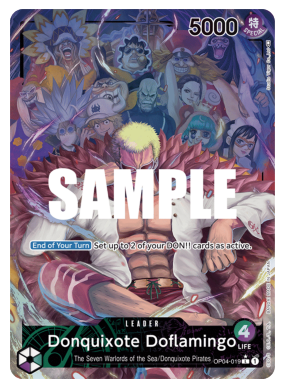

Match 3:
Card ID: OP01-024_p1.jpg
Distance: 0.8943315744400024


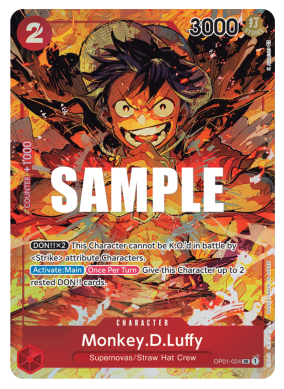

Match 4:
Card ID: ST01-012_p2.jpg
Distance: 0.9121163487434387


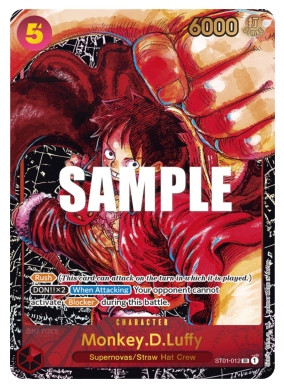

Match 5:
Card ID: OP06-069_p1.jpg
Distance: 0.9251429438591003


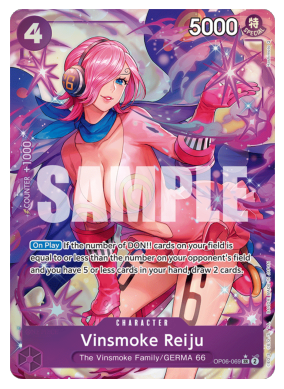

In [115]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
if top_k == 1:
    axes = [axes] 

for i, card_id in enumerate(closest_card_ids):
    image_path = find_image_path(card_id)
    if image_path:
        image = Image.open(image_path)
        print(f"Match {i + 1}:")
        print(f"Card ID: {card_id}")
        print(f"Distance: {closest_distances[i]}")
        plt.imshow(image)
        plt.axis('off')
        plt.show()

In [1]:
from ultralytics import YOLO


model = YOLO("yolov8n.pt") 
# Train the model
results = model.train(data="cards.yaml", epochs=60, imgsz=480)

Ultralytics YOLOv8.2.82 🚀 Python-3.12.0 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 12282MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=cards.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

/home/kono/.local/share/virtualenvs/tcg-scanner-gdmEvyDg/lib/python3.12/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /home/kono/projects/tcg-scanner/card_detector_dataset/labels/train.cache... 65 images, 3 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
val: Scanning /home/kono/projects/tcg-scanner/card_detector_dataset/labels/val.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 480 train, 480 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      1.26G      1.009       3.22      1.236         21        480: 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]

                   all         10         30    0.00881          1      0.153      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      1.24G     0.7978       2.99      1.075         21        480: 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.54it/s]

                   all         10         30    0.00895          1      0.349       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      1.24G     0.6243      2.257     0.9056         21        480: 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.25it/s]

                   all         10         30      0.647        0.4       0.53      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      1.22G     0.6539      1.561     0.9113         39        480: 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]

                   all         10         30      0.684        0.5      0.699      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      1.25G     0.5717      1.356     0.8947         31        480: 100%|██████████| 5/5 [00:00<00:00, 15.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.11it/s]

                   all         10         30      0.969        0.5      0.874      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      1.24G     0.5864      1.135     0.9013         34        480: 100%|██████████| 5/5 [00:00<00:00, 16.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.82it/s]

                   all         10         30       0.99        0.5      0.895      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      1.25G     0.6069     0.9706     0.9421         13        480: 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]

                   all         10         30      0.987        0.5      0.848      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      1.24G     0.5704      1.014     0.9166         19        480: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.48it/s]

                   all         10         30      0.993        0.5      0.876      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      1.25G     0.5273     0.9234     0.8778         12        480: 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.94it/s]

                   all         10         30          1      0.496      0.884      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      1.22G     0.5418      0.781     0.9074         25        480: 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.71it/s]

                   all         10         30      0.685        0.6       0.93      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      1.24G     0.5698     0.8878     0.9256         11        480: 100%|██████████| 5/5 [00:00<00:00, 15.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.65it/s]

                   all         10         30      0.731      0.716      0.941      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      1.25G     0.5712     0.8349     0.8931         40        480: 100%|██████████| 5/5 [00:00<00:00, 14.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]

                   all         10         30      0.921      0.887      0.981      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      1.25G     0.5469     0.7404     0.8834         26        480: 100%|██████████| 5/5 [00:00<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.09it/s]

                   all         10         30      0.922      0.916      0.984       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      1.24G     0.5248     0.7917     0.9023         18        480: 100%|██████████| 5/5 [00:00<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.38it/s]

                   all         10         30      0.925      0.994      0.995      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      1.25G     0.5762     0.8083     0.8883         16        480: 100%|██████████| 5/5 [00:00<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.01it/s]

                   all         10         30      0.922      0.902      0.986      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      1.25G      0.528     0.7463     0.8901         17        480: 100%|██████████| 5/5 [00:00<00:00, 15.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.06it/s]

                   all         10         30      0.884      0.838      0.963      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      1.23G     0.5114     0.7054     0.8684         26        480: 100%|██████████| 5/5 [00:00<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.05it/s]

                   all         10         30      0.884      0.927      0.991      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      1.23G     0.5079      0.728     0.8776         43        480: 100%|██████████| 5/5 [00:00<00:00, 16.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]

                   all         10         30      0.922      0.978      0.995      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      1.24G     0.4961      0.818     0.8856          7        480: 100%|██████████| 5/5 [00:00<00:00, 17.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.33it/s]

                   all         10         30       0.95      0.995      0.995      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      1.25G     0.4615     0.6594     0.8478         21        480: 100%|██████████| 5/5 [00:00<00:00, 14.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.51it/s]

                   all         10         30      0.921      0.973      0.994      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      1.23G      0.477     0.6707     0.8792         19        480: 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.82it/s]

                   all         10         30      0.896      0.962      0.993      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60       1.3G     0.4536     0.6278      0.869         27        480: 100%|██████████| 5/5 [00:00<00:00, 15.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]

                   all         10         30      0.923       0.98      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      1.25G     0.4746     0.7255     0.8546         25        480: 100%|██████████| 5/5 [00:00<00:00, 17.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.06it/s]


                   all         10         30      0.957          1      0.995      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      1.23G     0.4969     0.6743     0.8784         22        480: 100%|██████████| 5/5 [00:00<00:00, 15.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.45it/s]

                   all         10         30      0.866      0.881      0.994      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      1.22G     0.4664      0.667     0.8744         16        480: 100%|██████████| 5/5 [00:00<00:00, 16.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]

                   all         10         30      0.795      0.898      0.982      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      1.25G     0.4111     0.6534     0.8578         13        480: 100%|██████████| 5/5 [00:00<00:00, 14.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.46it/s]

                   all         10         30      0.961      0.921      0.992      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      1.25G      0.469     0.6101     0.8637         16        480: 100%|██████████| 5/5 [00:00<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.80it/s]

                   all         10         30      0.978          1      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      1.25G     0.4282     0.6719     0.8584         29        480: 100%|██████████| 5/5 [00:00<00:00, 14.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.39it/s]

                   all         10         30      0.992          1      0.995      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      1.23G     0.4133     0.5716     0.8722         15        480: 100%|██████████| 5/5 [00:00<00:00, 16.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.16it/s]

                   all         10         30      0.992          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      1.25G      0.406     0.5604     0.8508         23        480: 100%|██████████| 5/5 [00:00<00:00, 14.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]

                   all         10         30       0.99          1      0.995      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      1.26G     0.4427     0.6227     0.8709         40        480: 100%|██████████| 5/5 [00:00<00:00, 17.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.03it/s]

                   all         10         30      0.967      0.994      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      1.23G     0.4526     0.6415     0.8766         30        480: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.75it/s]

                   all         10         30      0.941      0.989      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      1.24G     0.4188      0.572     0.8592         35        480: 100%|██████████| 5/5 [00:00<00:00, 17.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.02it/s]

                   all         10         30      0.961          1      0.995      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      1.25G     0.4109     0.5736     0.8583         22        480: 100%|██████████| 5/5 [00:00<00:00, 16.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.69it/s]

                   all         10         30      0.971      0.983      0.995      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      1.24G     0.4465     0.5633      0.855         26        480: 100%|██████████| 5/5 [00:00<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]

                   all         10         30      0.961      0.981      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      1.25G     0.4093     0.5074     0.8736         28        480: 100%|██████████| 5/5 [00:00<00:00, 16.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.30it/s]

                   all         10         30      0.948      0.974      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      1.22G     0.3914     0.5125      0.837         20        480: 100%|██████████| 5/5 [00:00<00:00, 15.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.51it/s]

                   all         10         30      0.944      0.968      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      1.25G     0.4043     0.5071       0.85         26        480: 100%|██████████| 5/5 [00:00<00:00, 16.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.19it/s]

                   all         10         30      0.955      0.966      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      1.25G     0.4079     0.5731     0.8618         21        480: 100%|██████████| 5/5 [00:00<00:00, 16.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.11it/s]


                   all         10         30      0.948      0.965      0.995      0.958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      1.25G     0.3951     0.5756     0.8631         15        480: 100%|██████████| 5/5 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.90it/s]

                   all         10         30      0.948          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      1.22G     0.3815     0.5793     0.8323         45        480: 100%|██████████| 5/5 [00:00<00:00, 14.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.47it/s]

                   all         10         30      0.967          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      1.23G     0.3866     0.5291     0.8645         20        480: 100%|██████████| 5/5 [00:00<00:00, 17.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.84it/s]

                   all         10         30      0.972      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      1.24G     0.3976     0.5054     0.8471         22        480: 100%|██████████| 5/5 [00:00<00:00, 15.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.62it/s]

                   all         10         30      0.979          1      0.995      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      1.23G     0.3967     0.5264      0.878         13        480: 100%|██████████| 5/5 [00:00<00:00, 14.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.77it/s]

                   all         10         30      0.971      0.995      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      1.24G     0.3912     0.4994      0.843         19        480: 100%|██████████| 5/5 [00:00<00:00, 15.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.84it/s]

                   all         10         30      0.963      0.984      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60       1.3G     0.3979      0.524     0.8427         39        480: 100%|██████████| 5/5 [00:00<00:00, 15.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]

                   all         10         30      0.935      0.994      0.995      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      1.23G      0.376     0.4778     0.8433         22        480: 100%|██████████| 5/5 [00:00<00:00, 17.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.80it/s]

                   all         10         30      0.943      0.993      0.995      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      1.24G      0.379     0.5195     0.8599         19        480: 100%|██████████| 5/5 [00:00<00:00, 16.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.17it/s]

                   all         10         30      0.968          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      1.24G     0.3303     0.4626      0.831         30        480: 100%|██████████| 5/5 [00:00<00:00, 16.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.06it/s]

                   all         10         30      0.972      0.998      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      1.25G     0.3398     0.4855     0.8306         17        480: 100%|██████████| 5/5 [00:00<00:00, 15.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.57it/s]

                   all         10         30      0.973      0.996      0.995       0.96


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      1.23G     0.2923     0.5711     0.8114         27        480: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]

                   all         10         30      0.961      0.995      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      1.23G     0.3097     0.7204      0.798          4        480: 100%|██████████| 5/5 [00:00<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.80it/s]

                   all         10         30      0.961      0.975      0.994      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      1.22G     0.2849     0.5388     0.8183          6        480: 100%|██████████| 5/5 [00:00<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.05it/s]

                   all         10         30      0.959      0.975      0.994       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      1.23G     0.2969     0.6027     0.8189         18        480: 100%|██████████| 5/5 [00:00<00:00, 14.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.78it/s]

                   all         10         30      0.967      0.979      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      1.23G     0.2831      0.485     0.8037         16        480: 100%|██████████| 5/5 [00:00<00:00, 15.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.49it/s]

                   all         10         30      0.967      0.996      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      1.23G     0.2723     0.5325     0.7822         11        480: 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]

                   all         10         30      0.984          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      1.22G     0.2663     0.4848     0.7886          6        480: 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.75it/s]

                   all         10         30       0.99          1      0.995      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      1.23G     0.2804     0.5212     0.7868          4        480: 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.40it/s]

                   all         10         30      0.992          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      1.23G     0.2719     0.4568     0.7903         11        480: 100%|██████████| 5/5 [00:00<00:00, 16.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]

                   all         10         30      0.993          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      1.23G      0.267     0.4364     0.8037         13        480: 100%|██████████| 5/5 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]

                   all         10         30      0.993          1      0.995      0.967



60 epochs completed in 0.012 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.82 🚀 Python-3.12.0 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 12282MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.51it/s]


                   all         10         30      0.992          1      0.995      0.977
                    op          5          5      0.987          1      0.995      0.995
               pokemon          5         25      0.998          1      0.995      0.958
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train3


In [25]:
model = YOLO("best.pt") 
image = Image.open("card_detector_dataset/images/train/IMG_3291.JPG")
image = image.convert("RGB")


0: 384x480 2 ops, 4.1ms
Speed: 0.9ms preprocess, 4.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 480)
tensor([[1904.0797, 1343.5459, 2624.6594, 2446.5381]], device='cuda:0')


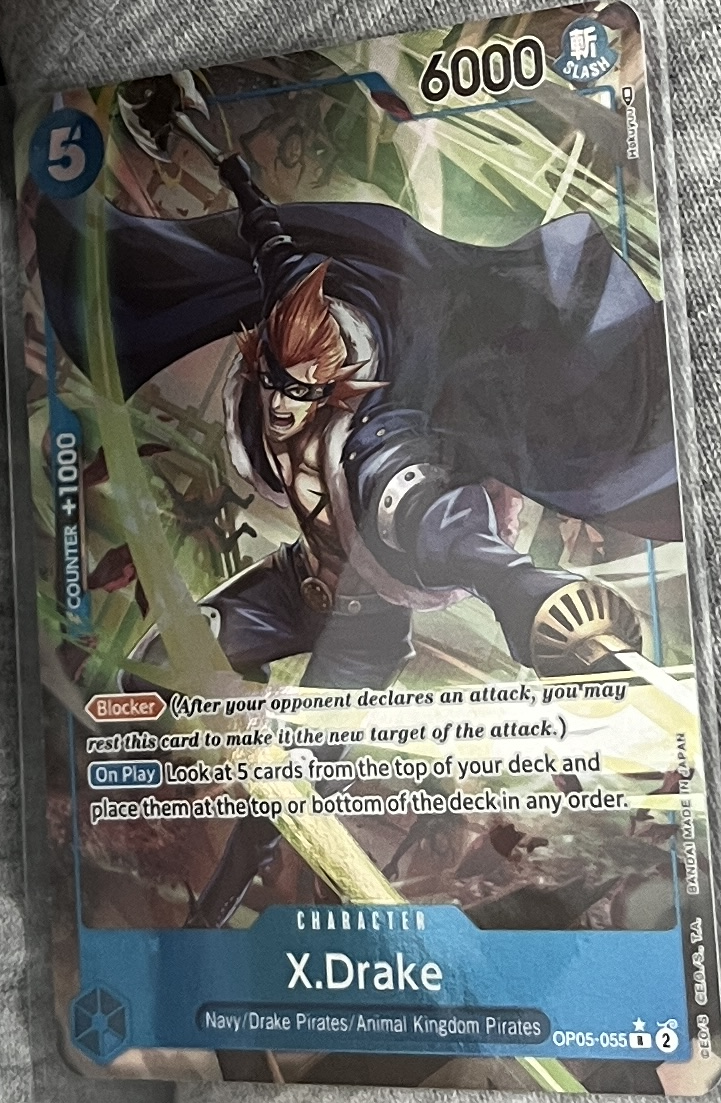

tensor([[1273.7097,    0.0000, 2153.4888,  992.8548]], device='cuda:0')


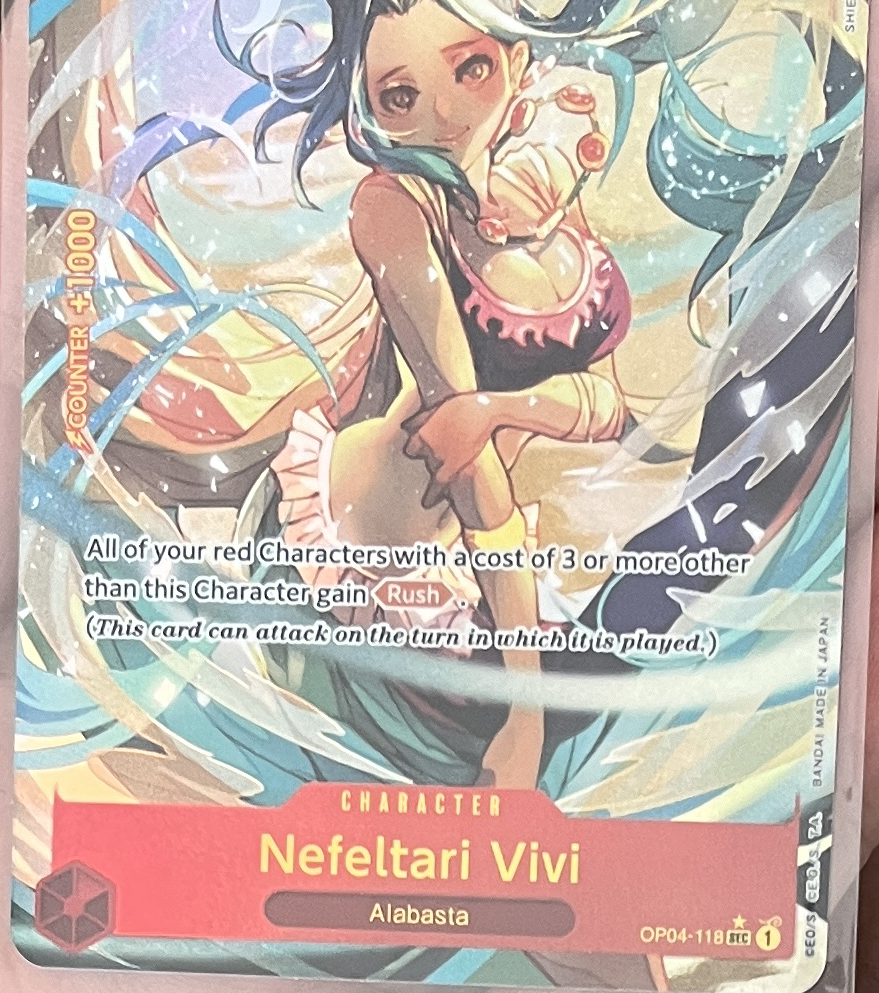

In [26]:
from ultralytics.engine.results import Boxes
image = image.rotate(270)
results = model(image)
# Process results list
for box in results[0].boxes:
    print(box.xyxy)
    b = box.xyxy[0].tolist()
    cropped_image = image.crop((b[0], b[1], b[2], b[3]))
    cropped_image.show()